In [4]:
!pip install pandas

In [5]:
import pandas as pd
my_file_path = r"C:\Users\user\Desktop\iit\year2 sem1\sdgp\AgroEdge\farming data2.csv"
farming_data=pd.read_csv(my_file_path)
farming_data.head()

,Farmer Name,Farm ID,Farm Size (Perches),Farm Type,Farm Location (Village),Farm Location (District),Crop Type,Brinjal Variety,Planting Start Date,Planting End Date,...,Total Water Usage (liters),Irrigation Schedule,Irrigation Cost (Rs.),Total Number of Labor Hours,Total Labor Wages,Market Selling Price (Rs./kg),Total Sales Revenue (Rs.),Profit/Loss (Rs.),Buyer Type,Storage Method
0,Eran Wickramasinghe,6710,9.0,Organic,Hanwella,Colombo,Brinjal,Local,27/10/2024,20/01/2025,...,159219.33,Daily,4045.21,8,2453.45,154.11,40680.42,4040.16,Retail,Refrigeration
1,Chandana Fernando,7527,112.0,Mixed,Minuwangoda,Gampaha,Brinjal,Other,07/05/2024,28/08/2024,...,1505123.64,Weekly,1735.96,8,1399.81,100.71,27617.70,8243.59,Retail,Refrigeration
2,Amara Perera,4828,182.4,Conventional,Bulathsinhala,Kalutara,Brinjal,Hybrid,27/07/2024,16/11/2024,...,2481867.21,Daily,3469.49,9,2561.95,371.97,109366.62,76595.58,Direct Consumers,Refrigeration
3,Chandana Fernando,5629,352.0,Mixed,Pussellawa,Kandy,Brinjal,Hybrid,23/06/2023,04/10/2023,...,4903479.39,Based on moisture levels,643.28,5,2609.61,444.54,87294.32,67207.80,Retail,Refrigeration
4,Dinesh Kumara,5543,441.6,Mixed,Rattota,Matale,Brinjal,Other,14/03/2023,21/05/2023,...,7335547.72,Based on moisture levels,3593.12,8,2025.32,313.02,139995.06,111829.22,Wholesale,Refrigeration


In [6]:
print(farming_data.isnull().sum())

Farmer Name                         0
Farm ID                             0
Farm Size (Perches)                 0
Farm Type                           0
Farm Location (Village)             0
Farm Location (District)            0
Crop Type                           0
Brinjal Variety                     0
Planting Start Date                 0
Planting End Date                   0
Expected Harvest (kg)               0
Actual Harvest (kg)                 0
Soil Type                           0
Soil pH Level                       1
Seed Type                           0
Seed Variety                        0
Seed Source                         0
Seed Quantity (g)                   0
Seed Cost (Rs.)                     0
Fertilizer Type                     0
Fertilizer Brand                    0
Total Fertilizer Quantity (kg)      0
Fertilizer N-P-K Ratio              0
Fertilizer Application Schedule     0
Fertilizer Application Method       0
Fertilizer Cost (Rs.)               0
Pesticide Ty

In [7]:
import numpy as np
from scipy.stats import zscore

logical_min_threshold = 10 #asume the smallest value that can be farmsize

# Compute IQR (Interquartile Range)
Q1 = farming_data['Farm Size (Perches)'].quantile(0.25)  # 25th percentile
Q3 = farming_data['Farm Size (Perches)'].quantile(0.75)  # 75th percentile

IQR = Q3 - Q1   #calculate IQR

upper_bound_iqr= Q3 + 1.2 * IQR # Compute an upper bound dynamically

#calculate zcore
z_scores = zscore(farming_data['Farm Size (Perches)']) 

# Identify outliers based on above criteria
outlier_indices = farming_data.index[
    (farming_data['Farm Size (Perches)'] < logical_min_threshold) |  # Very small values
    (farming_data['Farm Size (Perches)'] > upper_bound_iqr) |        # IQR-based high outliers
    (z_scores > 2.5)                                                 # Z-score-based extreme values
]
removed_outliers = farming_data.loc[outlier_indices, ['Farm Size (Perches)']]
#remove those outliers 
farming_data.loc[outlier_indices, 'Farm Size (Perches)'] = np.nan
print(removed_outliers)


    Farm Size (Perches)
0                   9.0
11                  8.0
12                  7.0
49                  8.0
59                  7.0
75                  6.0
85                  9.0


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Avoid division errors (if Farm Size is 0 or NaN)
valid_farm_data = farming_data[farming_data['Farm Size (Perches)'] > 0].copy()

# Compute Expected Yield per Perch dynamically
expected_yield_per_perch = valid_farm_data['Expected Harvest (kg)'] / valid_farm_data['Farm Size (Perches)']

# Ensure index matches with the original dataset
expected_yield_per_perch = expected_yield_per_perch.reindex(farming_data.index, fill_value=np.nan)

# Compute IQR for 'Expected Yield per Perch'
Q1 = expected_yield_per_perch.quantile(0.25)
Q3 = expected_yield_per_perch.quantile(0.75)
IQR = Q3 - Q1

# Compute IQR-based limits
upper_bound_iqr = Q3 + 1.5 * IQR  # Upper threshold
lower_bound_iqr = max(Q1 - 1.5 * IQR, 0.1)  # Lower threshold (avoiding zero)

# Compute Z-score for extreme high values dynamically
z_scores = np.abs(zscore(expected_yield_per_perch, nan_policy="omit"))

# Identify Outliers based on Yield per Perch
outlier_mask = (
    (expected_yield_per_perch < lower_bound_iqr) | 
    (expected_yield_per_perch > upper_bound_iqr) |
    (z_scores > 3)  # Extreme high values only
)

# Extract and print the detected outliers (Now the index matches)
outliers_df = farming_data.loc[outlier_mask, ['Farm Size (Perches)', 'Expected Harvest (kg)']]
print("Detected Unrealistic Expected Harvest Values (Based on Farm Size):")
print(outliers_df)

# Replace only outlier values with NaN (keeping the row intact)
farming_data.loc[outlier_mask, 'Expected Harvest (kg)'] = np.nan


Detected Unrealistic Expected Harvest Values (Based on Farm Size):
Empty DataFrame
Columns: [Farm Size (Perches), Expected Harvest (kg)]
Index: []


In [9]:
# Ensure we have no zero farm sizes to avoid division errors
valid_farm_data = farming_data[farming_data['Farm Size (Perches)'] > 0].copy()

# Compute "Actual Yield per Perch" dynamically (without adding a new column)
actual_yield_per_perch = valid_farm_data['Actual Harvest (kg)'] / valid_farm_data['Farm Size (Perches)']

# Reindex to match original farming_data to avoid indexing errors
actual_yield_per_perch = actual_yield_per_perch.reindex(farming_data.index, fill_value=np.nan)

# Compute IQR for "Actual Yield per Perch"
Q1 = actual_yield_per_perch.quantile(0.25)  # 25th percentile
Q3 = actual_yield_per_perch.quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range (spread of the middle 50% of data)

# Set thresholds for identifying outliers using IQR
upper_bound_iqr = Q3 + 1.5 * IQR  # Any value above this is considered an outlier
lower_bound_iqr = max(Q1 - 1.5 * IQR, 0.1)  # Any value below this is also an outlier (but avoid zero or negative values)

# Compute Z-score for extreme values dynamically
z_scores = np.abs(zscore(actual_yield_per_perch, nan_policy="omit"))

# Identify outliers based on "Actual Yield per Perch"
outlier_mask = (
    (actual_yield_per_perch < lower_bound_iqr) | 
    (actual_yield_per_perch > upper_bound_iqr) |  
    (z_scores > 3)  # Extreme outliers (Z-score greater than 3)
)

# Extract detected outliers
outliers_df = farming_data.loc[outlier_mask, ['Farm Size (Perches)', 'Actual Harvest (kg)']]

# Display detected outliers using standard pandas display
print("\nDetected Outliers in Actual Harvest:")
print(outliers_df)

# Replace only outlier values with NaN (keeping the row intact)
farming_data.loc[outlier_mask, 'Actual Harvest (kg)'] = np.nan


Detected Outliers in Actual Harvest:
Empty DataFrame
Columns: [Farm Size (Perches), Actual Harvest (kg)]
Index: []


In [10]:
# Ensure valid farm sizes to prevent division errors
valid_farm_data = farming_data[farming_data['Farm Size (Perches)'] > 0].copy()

# Compute "Seed Usage per Perch" dynamically (without modifying dataset)
seed_usage_per_perch = valid_farm_data['Seed Quantity (g)'] / valid_farm_data['Farm Size (Perches)']

# Reindex to match original farming_data
seed_usage_per_perch = seed_usage_per_perch.reindex(farming_data.index, fill_value=np.nan)

# Compute IQR for "Seed Usage per Perch"
Q1 = seed_usage_per_perch.quantile(0.25)
Q3 = seed_usage_per_perch.quantile(0.75)
IQR = Q3 - Q1

# Adjust outlier detection criteria
upper_bound_iqr = Q3 + 2 * IQR  # Increased IQR multiplier
lower_bound_iqr = max(Q1 - 2 * IQR, 0.5)  # More relaxed lower bound

# Adjust Z-score threshold
z_score_threshold = 3.5  # Less strict than 3

# Compute Z-score
z_scores = np.abs(zscore(seed_usage_per_perch, nan_policy="omit"))

# Identify outliers
outlier_mask = (
    (seed_usage_per_perch < lower_bound_iqr) |
    (seed_usage_per_perch > upper_bound_iqr) |
    (z_scores > z_score_threshold)
)

# Extract and display detected outliers
outliers_df = farming_data.loc[outlier_mask, ['Farm Size (Perches)', 'Seed Quantity (g)']]
print("Updated Detected Outliers in Seed Quantity (g):")
print(outliers_df)

# Replace only outlier values with NaN (keeping the row intact)
farming_data.loc[outlier_mask, 'Seed Quantity (g)'] = np.nan


Updated Detected Outliers in Seed Quantity (g):
    Farm Size (Perches)  Seed Quantity (g)
21                580.8                  5
25                796.8                 50
28                 10.0              10000


In [11]:
# Ensure valid farm sizes to prevent division errors
valid_farm_data = farming_data[farming_data['Farm Size (Perches)'] > 0].copy()

# Compute "Water Usage per Perch" dynamically (without modifying dataset)
water_usage_per_perch = valid_farm_data['Total Water Usage (liters)'] / valid_farm_data['Farm Size (Perches)']

# Reindex to match original farming_data
water_usage_per_perch = water_usage_per_perch.reindex(farming_data.index, fill_value=np.nan)

# Compute IQR for "Water Usage per Perch"
Q1 = water_usage_per_perch.quantile(0.25)
Q3 = water_usage_per_perch.quantile(0.75)
IQR = Q3 - Q1

# Compute IQR-based outlier limits
upper_bound_iqr = Q3 + 1.5 * IQR  # Upper threshold
lower_bound_iqr = max(Q1 - 1.5 * IQR, 10)  # Lower threshold (avoiding zero or too small values)

# Compute Z-score for extreme values
z_scores = np.abs(zscore(water_usage_per_perch, nan_policy="omit"))

# Identify outliers based on "Water Usage per Perch"
outlier_mask = (
    (water_usage_per_perch < lower_bound_iqr) |  # Too low
    (water_usage_per_perch > upper_bound_iqr) |  # Too high
    (z_scores > 3)  # Extreme outliers
)

# Extract detected outliers
outliers_df = farming_data.loc[outlier_mask, ['Farm Size (Perches)', 'Irrigation Method', 'Total Water Usage (liters)']]

# Print detected outliers
print("Detected Outliers in Total Water Usage (liters):")
print(outliers_df)

# Replace only outlier values with NaN (keeping the row intact)
farming_data.loc[outlier_mask, 'Total Water Usage (liters)'] = np.nan

Detected Outliers in Total Water Usage (liters):
    Farm Size (Perches) Irrigation Method  Total Water Usage (liters)
55                192.0         Sprinkler                     10000.0
66                291.2         Sprinkler                 100000000.0
84                321.6  Flood Irrigation                  50000000.0


In [12]:
import pandas as pd
# Define the updated function with rounding to two decimal places
def fill_soil_ph(row):
    if pd.isnull(row['Soil pH Level']):  
        # Filter data for the same village
        village_data = farming_data[farming_data['Farm Location (Village)'] == row['Farm Location (Village)']]
        
        # Check if the village has at least 2 records with valid data
        if village_data['Soil pH Level'].count() >= 2:
            village_mean = round(village_data['Soil pH Level'].mean(skipna=True), 2)
            print(f"Filling missing value using village mean ({row['Farm Location (Village)']}): {village_mean}")
            return village_mean
        
        # If no valid data in the village, check the district
        district_data = farming_data[farming_data['Farm Location (District)'] == row['Farm Location (District)']]
        
        # Check if the district has at least 2 records with valid data
        if district_data['Soil pH Level'].count() >= 2:
            district_mean = round(district_data['Soil pH Level'].mean(skipna=True), 2)
            print(f"Filling missing value using district mean ({row['Farm Location (District)']}): {district_mean}")
            return district_mean
        
        # If neither village nor district has at least 2 valid records, return the global mean
        global_mean = round(farming_data['Soil pH Level'].mean(skipna=True), 2)
        print(f"Filling missing value using global mean: {global_mean}")
        return global_mean
    
    return row['Soil pH Level']  

# Apply function to fill missing values
farming_data['Soil pH Level'] = farming_data.apply(fill_soil_ph, axis=1)

# Check if any NaN values remain
missing_values = farming_data['Soil pH Level'].isnull().sum()

# Print the total number of missing values left
print(f"Total missing values remaining: {missing_values}")

Filling missing value using district mean (Kandy): 5.86
Total missing values remaining: 0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Select relevant features for predicting Farm Size (Perches)
features = ['Expected Harvest (kg)', 'Actual Harvest (kg)', 'Seed Quantity (g)',
            'Total Fertilizer Quantity (kg)', 'Fertilizer Cost (Rs.)', 
            'Total Pesticide Quantity (kg)', 'Total Water Usage (liters)', 
            'Total Sales Revenue (Rs.)']

# Separate rows with and without missing values in "Farm Size (Perches)"
train_data = farming_data.dropna(subset=['Farm Size (Perches)'])
test_data = farming_data[farming_data['Farm Size (Perches)'].isna()]

# Prepare training data
X_train = train_data[features]
y_train = train_data['Farm Size (Perches)']

# Handle missing values in features by filling with median (for training)
X_train.fillna(X_train.median(), inplace=True)

# Train a regression model (Random Forest for better prediction)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prepare test data
X_test = test_data[features]
X_test.fillna(X_test.median(), inplace=True)

# Predict missing Farm Sizes
predicted_farm_sizes = model.predict(X_test)

# Fill missing values with predicted values
farming_data.loc[farming_data['Farm Size (Perches)'].isna(), 'Farm Size (Perches)'] = predicted_farm_sizes.round(2)

# Extract the rows where "Farm Size (Perches)" was previously missing
predicted_farm_sizes_df = farming_data.loc[test_data.index, ['Farm Size (Perches)']]

# Print the predicted values with corresponding farmer details
print("Predicted Farm Size (Perches) for Previously Missing Values:")
print(predicted_farm_sizes_df)

C:\Users\user\AppData\Local\Temp\ipykernel_36392\399748675.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.median(), inplace=True)


Predicted Farm Size (Perches) for Previously Missing Values:
    Farm Size (Perches)
0                 24.35
11                39.07
12                56.59
49                30.04
59                19.04
75                38.50
85                31.53


C:\Users\user\AppData\Local\Temp\ipykernel_36392\399748675.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.median(), inplace=True)


In [14]:
# Select relevant features for predicting Expected Harvest (kg)
features = ['Farm Size (Perches)', 'Seed Quantity (g)', 'Total Fertilizer Quantity (kg)',
            'Fertilizer Cost (Rs.)', 'Total Pesticide Quantity (kg)', 
            'Total Water Usage (liters)', 'Total Sales Revenue (Rs.)']

# Separate rows with and without missing values in "Expected Harvest (kg)"
train_data = farming_data.dropna(subset=['Expected Harvest (kg)'])
test_data = farming_data[farming_data['Expected Harvest (kg)'].isna()]

# Prepare training data
X_train = train_data[features]
y_train = train_data['Expected Harvest (kg)']

# Handle missing values in features by filling with median (for training)
X_train.fillna(X_train.median(), inplace=True)

# Train a regression model (Random Forest for better prediction)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prepare test data
X_test = test_data[features]
X_test.fillna(X_test.median(), inplace=True)

# Predict missing Expected Harvest values
predicted_expected_harvest = model.predict(X_test)

# Fill missing values with predicted values (rounded to 2 decimal places)
farming_data.loc[farming_data['Expected Harvest (kg)'].isna(), 'Expected Harvest (kg)'] = np.round(predicted_expected_harvest, 2)

# Extract the filled values for reference
predicted_harvest_df = farming_data.loc[test_data.index, ['Expected Harvest (kg)']]

# Print predicted values for missing Expected Harvest
print("Predicted Expected Harvest (kg) for Previously Missing Values:")
print(predicted_harvest_df)

C:\Users\user\AppData\Local\Temp\ipykernel_36392\2043593444.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_36392\2043593444.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(X_test.median(), inplace=True)


ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
# Select relevant features for predicting Actual Harvest (kg)
features = ['Farm Size (Perches)', 'Expected Harvest (kg)', 'Seed Quantity (g)',
            'Total Fertilizer Quantity (kg)', 'Fertilizer Cost (Rs.)', 
            'Total Pesticide Quantity (kg)', 'Total Water Usage (liters)', 
            'Total Sales Revenue (Rs.)']

# Check for missing values in Actual Harvest (kg)
missing_count = farming_data['Actual Harvest (kg)'].isna().sum()
print("Missing values count in 'Actual Harvest (kg)':", missing_count)

if missing_count > 0:
    # Separate rows with and without missing values in "Actual Harvest (kg)"
    train_data = farming_data.dropna(subset=['Actual Harvest (kg)'])
    test_data = farming_data[farming_data['Actual Harvest (kg)'].isna()]

    # Prepare training data
    X_train = train_data[features]
    y_train = train_data['Actual Harvest (kg)']

    # Handle missing values in features by filling with median
    X_train.fillna(X_train.median(), inplace=True)

    # Train a regression model (Random Forest for better prediction)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prepare test data
    X_test = test_data[features]
    X_test.fillna(X_train.median(), inplace=True)

    # Debugging: Check if X_test is empty
    print("X_test shape before prediction:", X_test.shape)

    if not X_test.empty:
        # Predict missing Actual Harvest values
        predicted_actual_harvest = model.predict(X_test)

        # Fill missing values with predicted values (rounded to 2 decimal places)
        farming_data.loc[farming_data['Actual Harvest (kg)'].isna(), 'Actual Harvest (kg)'] = np.round(predicted_actual_harvest, 2)

        # Extract the filled values for reference
        predicted_harvest_df = farming_data.loc[test_data.index, ['Actual Harvest (kg)']]

        # Print predicted values
        print("Predicted Actual Harvest (kg) for Previously Missing Values:")
        print(predicted_harvest_df)
    else:
        print("No valid test samples available for prediction.")

else:
    print("No missing values in 'Actual Harvest (kg)'. No prediction needed.")

In [ ]:
print(farming_data.isnull().sum())

In [ ]:
df_kandy = farming_data[farming_data["Farm Location (District)"] == "Kandy"]

# Get the count and sum of pH values
ph_count = df_kandy["Soil pH Level"].count()
ph_sum = df_kandy["Soil pH Level"].sum()
print(ph_count)
print(ph_sum)

In [ ]:
print("Duplicate rows:",farming_data.duplicated().sum())

In [ ]:
farming_data= farming_data.drop_duplicates()

In [ ]:
print("Duplicate rows:",farming_data.duplicated().sum())


In [ ]:
farming_data.to_csv("cleaned_farmer_data.csv", index=False)


In [ ]:
#calculation for to give score by each creteria trough cleaned_farmer_data.csv
clean_farming_data= pd.read_csv("cleaned_farmer_data.csv")

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset (Update file path if needed)
file_path = r"C:\Users\user\Desktop\iit\year2 sem1\sdgp\AgroEdge\cleaned_farmer_data1.csv"
clean_farming_data = pd.read_csv(file_path)

# Compute KPIs (but don't add to dataframe yet)
yield_per_perch = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Farm Size (Perches)"]

total_cost = (clean_farming_data["Seed Cost (Rs.)"] + clean_farming_data["Fertilizer Cost (Rs.)"] +
              clean_farming_data["Pesticide Cost (Rs.)"] + clean_farming_data["Irrigation Cost (Rs.)"] +
              clean_farming_data["Total Labor Wages"].astype(float))

# Save just the Total Cost - this one is needed as per your requirements
clean_farming_data["Total Cost (Rs.)"] = total_cost

cost_per_kg = total_cost / clean_farming_data["Actual Harvest (kg)"]
roi = clean_farming_data["Profit/Loss (Rs.)"] / total_cost
fertilizer_efficiency = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Total Fertilizer Quantity (kg)"]
pesticide_efficiency = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Total Pesticide Quantity (kg)"]
water_efficiency = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Total Water Usage (liters)"]
labor_efficiency = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Total Number of Labor Hours"]
seed_efficiency = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Seed Quantity (g)"]

# Define function for Z-Score Normalization
def z_score_normalization(values, inverse=False):
    mean_val = values.mean()
    std_dev = values.std()
    
    if std_dev == 0:  # Avoid division by zero if there's no variance
        return np.full(len(values), 50)
    
    z_scores = (values - mean_val) / std_dev
    
    if inverse:  # Invert the scale for negative criteria (lower is better)
        z_scores = -z_scores
    
    return 50 + (z_scores * 10)  # Convert to 0-100 scale

# Normalize each KPI and store directly to dataframe (0-100 scale using Z-score)
clean_farming_data["Yield per Perch"] = z_score_normalization(yield_per_perch)
clean_farming_data["Cost per kg"] = z_score_normalization(cost_per_kg, inverse=True)  # Lower is better
clean_farming_data["ROI"] = z_score_normalization(roi)
clean_farming_data["Fertilizer Efficiency"] = z_score_normalization(fertilizer_efficiency)
clean_farming_data["Pesticide Efficiency"] = z_score_normalization(pesticide_efficiency)
clean_farming_data["Water Efficiency"] = z_score_normalization(water_efficiency)
clean_farming_data["Labor Efficiency"] = z_score_normalization(labor_efficiency)
clean_farming_data["Seed Efficiency"] = z_score_normalization(seed_efficiency)

# Define weights for each metric (Total = 100%)
weights = {
    "Yield per Perch": 0.25,
    "Cost per kg": 0.20,
    "ROI": 0.15,
    "Fertilizer Efficiency": 0.10,
    "Pesticide Efficiency": 0.08,
    "Water Efficiency": 0.07,
    "Labor Efficiency": 0.10,
    "Seed Efficiency": 0.05,
}

# Compute Final Performance Score
clean_farming_data["Final Performance Score"] = sum(clean_farming_data[col] * weight for col, weight in weights.items())



# Save the updated dataframe back to the same CSV file
clean_farming_data = clean_farming_data.round(2)  # Round all numeric values to 2 decimal places
clean_farming_data.to_csv(file_path, index=False)


# Function to generate a performance report for a specific Farm ID
def get_farmer_report_by_id(farm_id):
    farmer_data = clean_farming_data[clean_farming_data["Farm ID"] == farm_id]
    
    if farmer_data.empty:
        return f"🚨 No farmer found with Farm ID: {farm_id}"
    
    final_score = farmer_data["Final Performance Score"].values[0]
    
    report = f"📍 **Farm ID**: {int(farm_id)}\n📍 **Final Score**: {final_score:.2f} / 100\n\n"
    report += "Criterion                 Score (0-100)   Weight (%)      Weighted Contribution\n"
    report += "===============================================================================\n"
    
    for criterion, weight in weights.items():
        score = farmer_data[criterion].values[0]
        weighted_contribution = score * weight
        report += f"{criterion:<25} {score:>6.2f}          {weight*100:>5.2f}           {weighted_contribution:>6.2f}\n"
    
    report += "==============================================================================="

    return report

# Example usage: Get the report for a specific Farm ID (change the ID as needed)
farm_id_to_check = 5610  # Change this ID to any farmer's ID you want to check
print(get_farmer_report_by_id(farm_id_to_check))

📍 **Farm ID**: 5610
📍 **Final Score**: 53.97 / 100

Criterion                 Score (0-100)   Weight (%)      Weighted Contribution
Yield per Perch            55.25          25.00            13.81
Cost per kg                53.49          20.00            10.70
ROI                        40.85          15.00             6.13
Fertilizer Efficiency      48.62          10.00             4.86
Pesticide Efficiency       72.38           8.00             5.79
Water Efficiency           51.79           7.00             3.63
Labor Efficiency           61.18          10.00             6.12
Seed Efficiency            58.69           5.00             2.93


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows wi

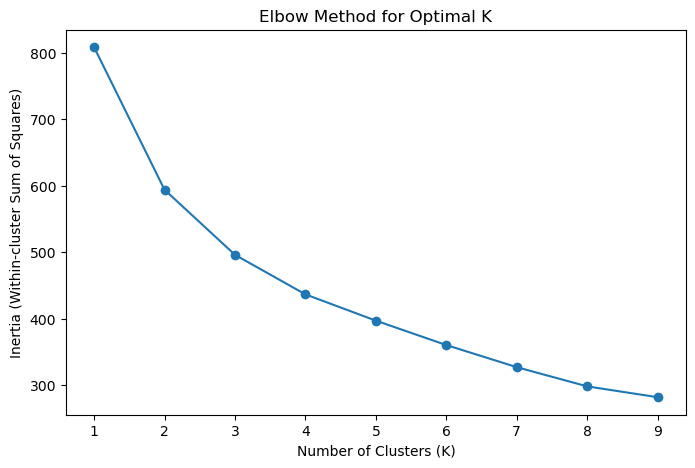

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Enhanced recommendations saved to: enhanced_farmer_recommendations.csv
Enter Farm ID: 1840
📌 Recommendation for Farm ID 1840:
🔹 Consider switching seed type to 'GMO' for better results.
🔹 Consider switching seed variety to 'Variety-7' for better results.
🔹 Consider switching seed source to 'Own-grown' for better results.
🔹 Consider switching fertilizer brand to 'Brand-1' for better results.
🔹 Consider switching fertilizer application schedule to 'Weekly' for better results.
🔹 Consider switching fertilizer application method to 'Soil Application' for better results.
🔹 Consider switching pesticide type to 'Chemical' for better results.
🔹 Consider switching pesticide application frequency to 'Weekly' for better results.
🔹 Consider switching pesticide application method to 'Drip Irrigation' for better results.
🔹 Consider switching irrigation method to 'Flood Irrigation' for better results.
🔹 Consider switching buyer type to 'Wholesale' for better results.
🔹 Optimize fertilizer usage by app

In [12]:
# Re-load necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Reload the dataset (file needs to be re-uploaded since execution state was reset)
file_path = r"C:\Users\user\Desktop\iit\year2 sem1\sdgp\AgroEdge\cleaned_farmer_data1.csv"
clean_farming_data = pd.read_csv(file_path)

# Standardize column names (strip spaces)
clean_farming_data.columns = clean_farming_data.columns.str.strip()

# Identify the actual column name for Farmer ID
expected_column_name = "Farm ID" 
actual_column_name = None

for col in clean_farming_data.columns:
    if col.lower() == expected_column_name.lower():  # Case-insensitive check
        actual_column_name = col
        break

if actual_column_name is None:
    raise KeyError("❌ 'Farmer ID' column not found. Check column names in your dataset.")

# Compute Yield per Perch
clean_farming_data["Yield per Perch"] = clean_farming_data["Actual Harvest (kg)"] / clean_farming_data["Farm Size (Perches)"]

# Compute Total Cost (Rs.)
clean_farming_data["Total Cost (Rs.)"] = (
    clean_farming_data["Seed Cost (Rs.)"] + clean_farming_data["Fertilizer Cost (Rs.)"] +
    clean_farming_data["Pesticide Cost (Rs.)"] + clean_farming_data["Irrigation Cost (Rs.)"] +
    clean_farming_data["Total Labor Wages"]
)

# Compute Cost per kg
clean_farming_data["Cost per kg"] = clean_farming_data["Total Cost (Rs.)"] / clean_farming_data["Actual Harvest (kg)"]

# Compute ROI (Return on Investment)
clean_farming_data["ROI"] = clean_farming_data["Profit/Loss (Rs.)"] / clean_farming_data["Total Cost (Rs.)"]

# Compute various efficiency metrics
clean_farming_data["Fertilizer Efficiency"] = clean_farming_data["Actual Harvest (kg)"] / (clean_farming_data["Total Fertilizer Quantity (kg)"] + 1e-6)
clean_farming_data["Pesticide Efficiency"] = clean_farming_data["Actual Harvest (kg)"] / (clean_farming_data["Total Pesticide Quantity (kg)"] + 1e-6)
clean_farming_data["Water Efficiency"] = clean_farming_data["Actual Harvest (kg)"] / (clean_farming_data["Total Water Usage (liters)"] + 1e-6)
clean_farming_data["Labor Efficiency"] = clean_farming_data["Actual Harvest (kg)"] / (clean_farming_data["Total Number of Labor Hours"] + 1e-6)
clean_farming_data["Seed Efficiency"] = clean_farming_data["Actual Harvest (kg)"] / (clean_farming_data["Seed Quantity (g)"] + 1e-6)

# Select features for clustering
selected_features = [
    "Yield per Perch", "Cost per kg", "ROI", "Fertilizer Efficiency",
    "Pesticide Efficiency", "Water Efficiency", "Labor Efficiency", "Seed Efficiency"
]

X = clean_farming_data[selected_features]

# Standardize the data (normalize features to have mean 0 and variance 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the Elbow Method to determine the optimal number of clusters
inertia = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

# Based on the Elbow Method, selecting the optimal number of clusters (K)
optimal_k = 3

# Apply K-Means clustering with the selected K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clean_farming_data["Cluster"] = kmeans.fit_predict(X_scaled)

# Assign cluster labels
clean_farming_data["Cluster Label"] = clean_farming_data["Cluster"].map({
    0: "High Performers",
    1: "Moderate Performers",
    2: "Low Performers"
})

# Compute cluster-based means for categorical recommendations
categorical_features = [
    "Soil Type", "Seed Type", "Seed Variety", "Seed Source", "Fertilizer Type", "Fertilizer Brand",
    "Fertilizer Application Schedule", "Fertilizer Application Method", "Pesticide Type", "Pesticide Application Frequency",
    "Pesticide Application Method", "Water Source", "Irrigation Method", "Irrigation Schedule", "Buyer Type"
]

# Store the most frequently used values for categorical features per cluster
cluster_categorical_modes = clean_farming_data.groupby("Cluster")[categorical_features].agg(lambda x: x.mode()[0])

# Step 8: Generate Enhanced Recommendations
def generate_enhanced_recommendations(row):
    recommendations = []
    cluster_id = row["Cluster"]

    # Compare categorical features
    for feature in categorical_features:
        best_value = cluster_categorical_modes.loc[cluster_id, feature]
        if row[feature] != best_value:
            recommendations.append(f"Consider switching {feature.lower()} to '{best_value}' for better results.")

    # Compare efficiency gaps
    if row["Fertilizer Efficiency"] < clean_farming_data["Fertilizer Efficiency"].mean():
        recommendations.append("Optimize fertilizer usage by applying better dosage based on soil tests.")

    if row["Pesticide Efficiency"] < clean_farming_data["Pesticide Efficiency"].mean():
        recommendations.append("Use targeted pesticide application to improve efficiency.")

    if row["Water Efficiency"] < clean_farming_data["Water Efficiency"].mean():
        recommendations.append("Consider switching to drip irrigation for better water utilization.")

    if row["Labor Efficiency"] < clean_farming_data["Labor Efficiency"].mean():
        recommendations.append("Optimize labor distribution and reduce unnecessary workforce hours.")

    if row["Yield per Perch"] < clean_farming_data["Yield per Perch"].mean():
        recommendations.append("Use higher-quality seeds and improve soil treatment for better yield.")

    if row["Seed Efficiency"] < clean_farming_data["Seed Efficiency"].mean():
        recommendations.append("Use certified seeds to enhance germination and crop output.")

    return "; ".join(recommendations) if recommendations else "No specific recommendation needed."

# Apply the enhanced recommendation generation
clean_farming_data["Enhanced Recommendations"] = clean_farming_data.apply(generate_enhanced_recommendations, axis=1)

# Save the recommendations to a CSV file
output_file = "enhanced_farmer_recommendations.csv"
clean_farming_data.to_csv(output_file, index=False)
print(f"Enhanced recommendations saved to: {output_file}")

# Function to get recommendations for a specific farmer based on their Farm ID
def get_recommendation_for_farmer(farm_id):
    if farm_id in clean_farming_data[actual_column_name].values:
        farmer_row = clean_farming_data[clean_farming_data[actual_column_name] == farm_id]
        recommendation = farmer_row["Enhanced Recommendations"].values[0]
        formatted_recommendations = "\n".join([f"🔹 {rec}" for rec in recommendation.split("; ")])
        return f"📌 Recommendation for Farm ID {farm_id}:\n{formatted_recommendations}"
    else:
        return "⚠️ Farm ID not found in the dataset."

# Example Usage: Ask user for Farm ID input
farm_id_to_check = int(input("Enter Farm ID: "))  
recommendation_output = get_recommendation_for_farmer(farm_id_to_check)  # Fixed function call
print(recommendation_output)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows wi

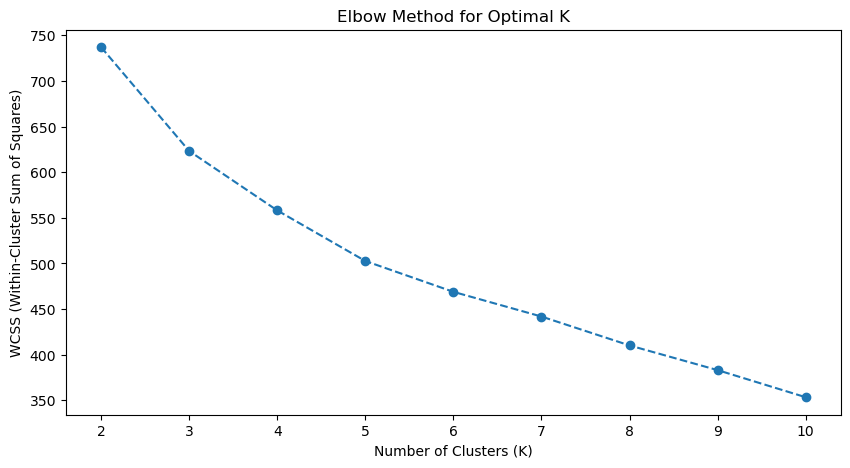

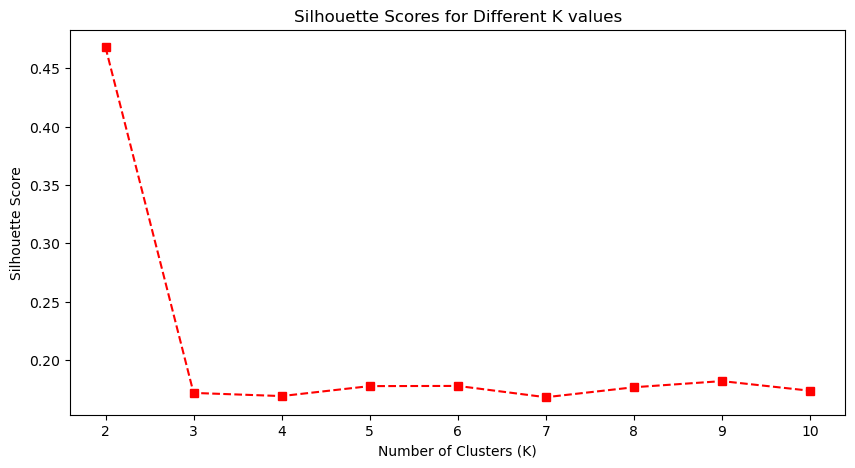

2

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


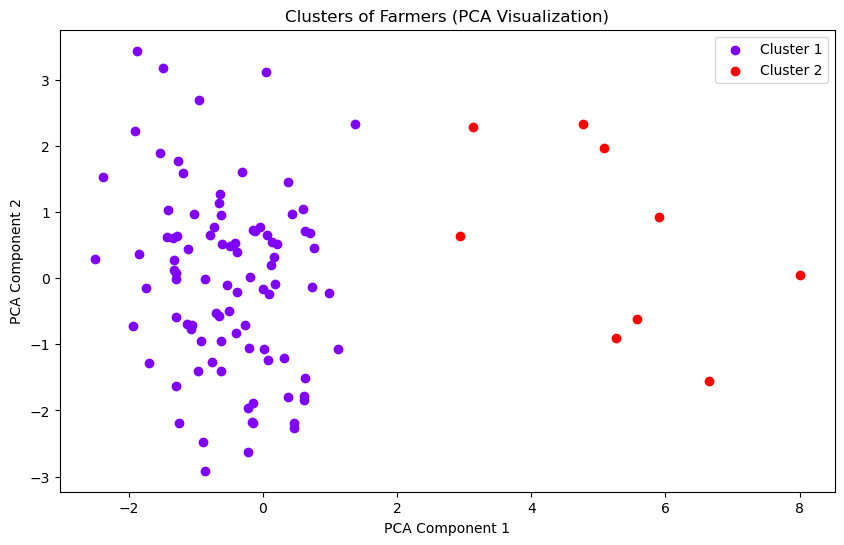

,Yield Score,Cost Efficiency Score,Fertilizer Score,Labor Score,Pesticide Score,Water Score,Soil Suitability Score,Market Price Score,ROI Score,Final Farmer Score,Cluster,PCA1,PCA2
0,-2.581276,-3.732804,-1.555982,-1.145302,-1.691174,-0.220800,-1.504554,-1.482483,-1.252351,-3.822773,1,6.647533,-1.552213
1,0.856087,0.222447,-0.194876,-0.929512,-0.460979,1.655014,-0.469905,-1.962589,-1.320656,-0.737941,0,0.463289,-2.265673
2,-0.249804,0.224284,1.223574,-0.893750,-0.715993,-0.085338,-0.936747,0.476085,0.373146,-0.082973,0,0.054248,0.648417
3,0.032603,0.324696,1.241583,-0.163337,-0.148576,0.176404,0.511019,1.128559,-0.043831,0.801278,0,-1.028384,0.971945
4,-0.361581,0.308165,1.226418,-0.447016,-0.661193,-1.369555,1.716102,-0.053924,0.992362,0.529061,0,-0.313402,1.597474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.376340,-3.023185,-1.566882,-1.147121,-1.709297,-0.665455,-1.311425,0.723882,2.310260,-1.223914,1,3.125564,2.278787
97,-0.384331,0.352248,-0.760740,0.687700,-0.384173,0.036349,-1.104866,0.167200,1.142813,-0.160619,0,0.169113,0.316655
98,-0.347732,0.174078,-0.136584,-0.636135,-0.574462,-0.698364,-0.854309,1.434003,-0.158567,0.002894,0,0.431772,0.961272
99,0.475751,0.333880,-0.045116,-0.244561,-0.523977,0.347072,-0.115142,0.159743,0.366896,0.304344,0,-0.381569,0.388509


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


✅ Cluster Characteristics saved to: C:\Users\user\Desktop\iit\year2 sem1\sdgp\AgroEdge\cluster_characteristics.csv


<Figure size 1200x600 with 0 Axes>

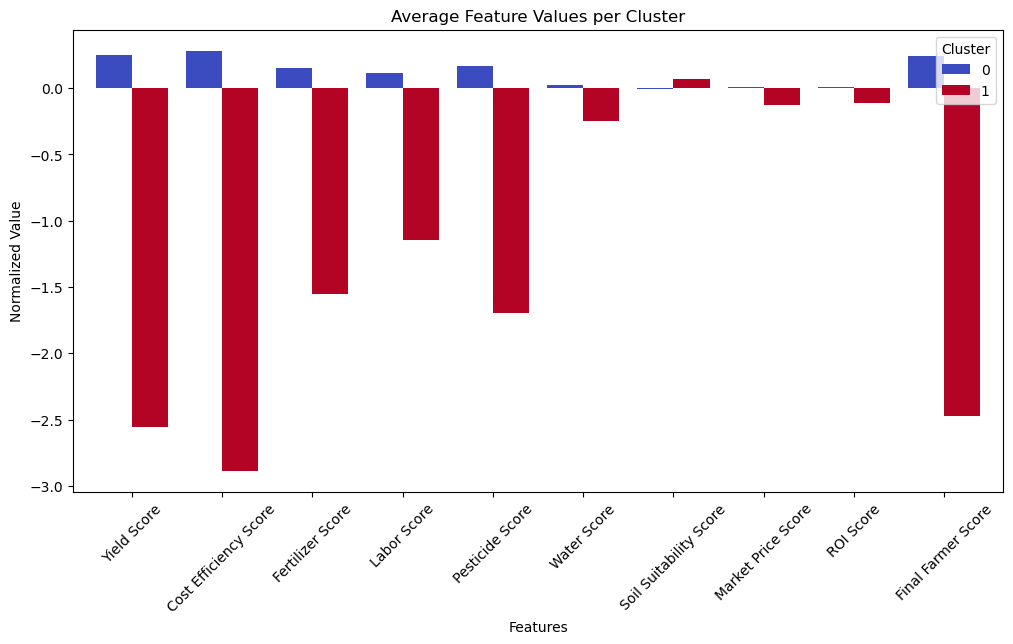